In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [20]:
data = pd.concat([train.loc[:, 'MSSubClass':'SaleCondition'], test.loc[:, 'MSSubClass':]], axis = 0) # Для совместной обработки
data_null = data.isnull().sum().loc[lambda x: x > 0]
drop_columns = data_null[lambda x: x>1400].index.tolist() # Удаляем столбцы со слишком большим количеством пропусков
data.drop(drop_columns, axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   LotShape       2919 non-null   object 
 6   LandContour    2919 non-null   object 
 7   Utilities      2917 non-null   object 
 8   LotConfig      2919 non-null   object 
 9   LandSlope      2919 non-null   object 
 10  Neighborhood   2919 non-null   object 
 11  Condition1     2919 non-null   object 
 12  Condition2     2919 non-null   object 
 13  BldgType       2919 non-null   object 
 14  HouseStyle     2919 non-null   object 
 15  OverallQual    2919 non-null   int64  
 16  OverallCond    2919 non-null   int64  
 17  YearBuilt      2919 non-null   int64  
 18  YearRemodAdd 

In [21]:
object_columns = data.select_dtypes('object').columns # Выбираем столбцы с категориальными признаками 

data['PoolArea'] = data['PoolArea'].apply(lambda x: True if x != 0 else False) # Заменяем некоторые числовые признаки с большой ассиметрией
data['EnclosedPorch'] = data['EnclosedPorch'].apply(lambda x: True if x != 0 else False)
data['3SsnPorch'] = data['3SsnPorch'].apply(lambda x: True if x != 0 else False)
data['LowQualFinSF'] = data['LowQualFinSF'].apply(lambda x: True if x != 0 else False)

data_object = data[object_columns].copy() #One-hot кодирование
data_object.fillna('null', inplace=True)
data_object = pd.get_dummies(data_object) 
data.drop(object_columns, axis=1, inplace = True)
null_columns = [col for col in data_object.columns if '_null' in col]
data_object = data_object.drop(null_columns, axis=1)
data = pd.concat([data, data_object], axis=1)

data.fillna(data.mean(), inplace = True) # Заполнение пропусков в числовых данных
columns = data.columns.tolist()

In [22]:
data_num = data.select_dtypes('int64', 'float64')
skewed_columns = data_num.columns[data_num.skew() > 5].tolist() # Столбцы с большой ассиметрией
not_skewed_columns = list(set(data_num.columns)-set(skewed_columns))

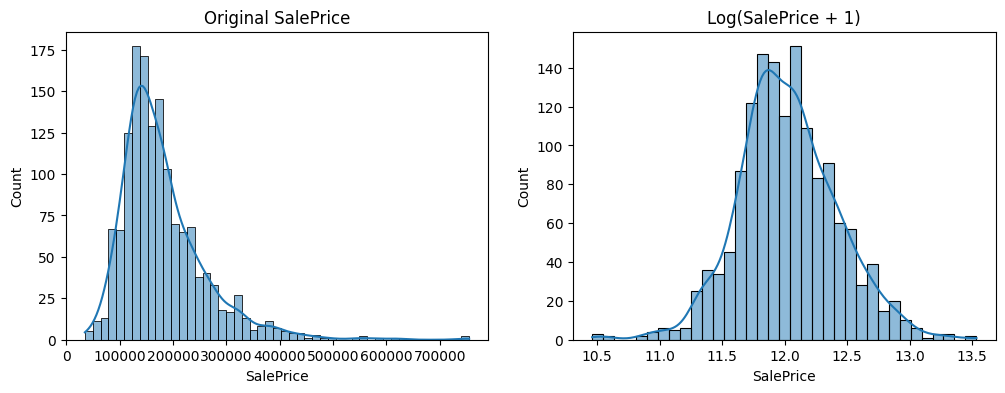

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(train['SalePrice'], kde=True)
plt.title('Original SalePrice')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train['SalePrice']), kde=True)  # np.log1p = log(x+1)
plt.title('Log(SalePrice + 1)')
plt.show()

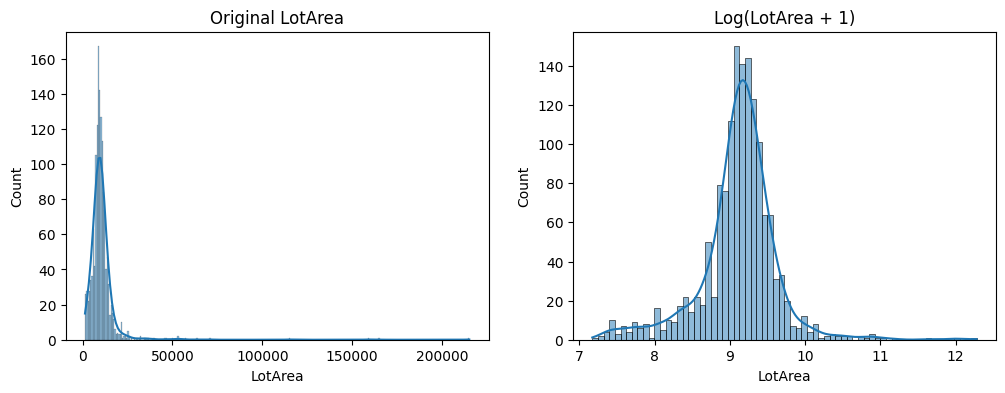

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(train['LotArea'], kde=True)
plt.title('Original LotArea')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train['LotArea']), kde=True)  # np.log1p = log(x+1)
plt.title('Log(LotArea + 1)')
plt.show()

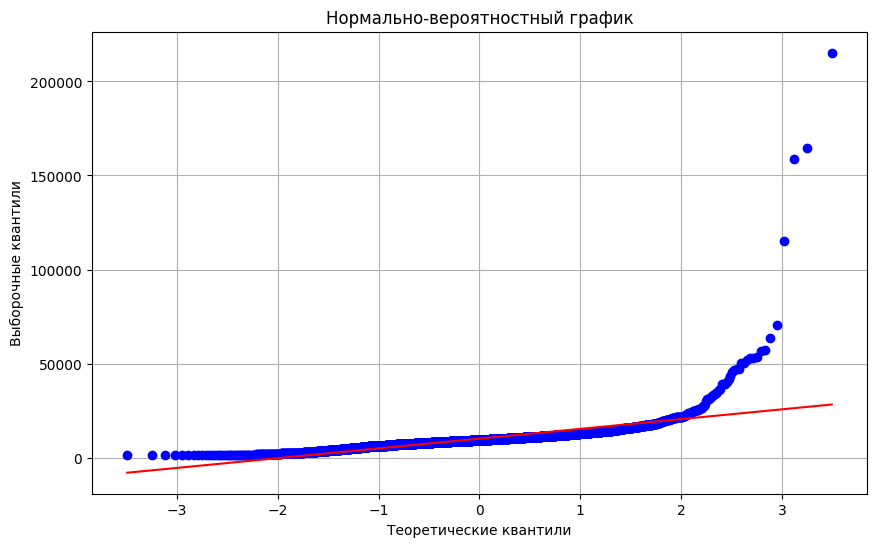

In [25]:
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(data['LotArea'], dist="norm", plot=plt)
plt.title('Нормально-вероятностный график')
plt.xlabel('Теоретические квантили')
plt.ylabel('Выборочные квантили')
plt.grid(True)
plt.show()

In [26]:
from sklearn.preprocessing import RobustScaler

for col in skewed_columns:
    data[col] = data[col].map(np.log1p) # Логарифмическое преобразование и z-преобразование
    data[col] = (data[col]-np.mean(data[col]))/np.std(data[col])

rob_scaler = RobustScaler()
data[not_skewed_columns] = rob_scaler.fit_transform(data[not_skewed_columns])

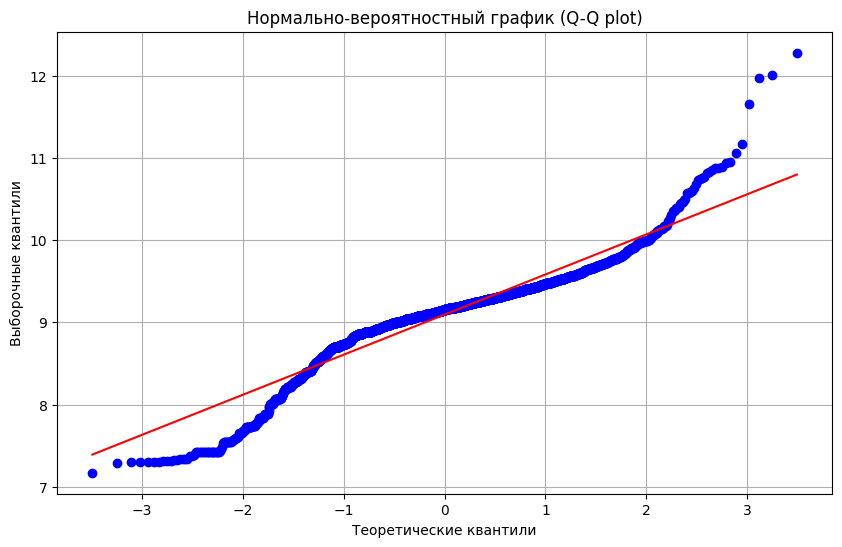

In [27]:
plt.figure(figsize=(10, 6))
stats.probplot(data['LotArea'], dist="norm", plot=plt)
plt.title('Нормально-вероятностный график (Q-Q plot)')
plt.xlabel('Теоретические квантили')
plt.ylabel('Выборочные квантили')
plt.grid(True)
plt.show()

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, make_scorer

X_train = data[:len(train)]
y_train = train['SalePrice'].map(np.log1p)  # Логарифмируем целевую переменную

X_test = data[len(train):]

def log_mae(y_true, y_pred):
    return mean_absolute_error(np.expm1(y_true), np.expm1(y_pred))  # Обратное преобразование для MAE

param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(2, 6),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.4, 1.0),
    'colsample_bytree': uniform(0.4, 1.0),
    'min_child_weight': randint(1, 10),
}

model_xgb = XGBRegressor(random_state=42, n_jobs=-1)

random_xgb = RandomizedSearchCV(
    model_xgb,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=make_scorer(log_mae, greater_is_better=False), 
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_xgb.fit(X_train, y_train)

print("Лучшие параметры:", random_xgb.best_params_)
print("Лучший MAE:", -random_xgb.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'colsample_bytree': 0.7047812581580291, 'learning_rate': 0.05939675594288252, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 417, 'subsample': 0.6221078104707303}
Лучший MAE: 15243.250115047089


In [11]:
from sklearn.ensemble import RandomForestRegressor

param_dist_rf = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(randint(5, 30).rvs(10)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_rf = RandomizedSearchCV(
    rf, 
    param_distributions=param_dist_rf,
    n_iter=50,
    cv=5,
    scoring=make_scorer(log_mae, greater_is_better=False),
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_rf.fit(X_train, y_train)

print("\nЛучшие параметры (RandomizedSearch):", random_rf.best_params_)
print("Лучший MAE (RandomizedSearch):", -random_rf.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Лучшие параметры (RandomizedSearch): {'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 185}
Лучший MAE (RandomizedSearch): 17542.62750741429


In [12]:
from sklearn.ensemble import GradientBoostingRegressor

param_dist_gb = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.2),  
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10)
}

gb = GradientBoostingRegressor(random_state=42)

random_gb = RandomizedSearchCV(
    gb,
    param_distributions=param_dist_gb,
    n_iter=50,
    cv=5,
    scoring=make_scorer(log_mae, greater_is_better=False),
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_gb.fit(X_train, y_train)

print("\nЛучшие параметры (RandomizedSearch):", random_gb.best_params_)
print("Лучший MAE (RandomizedSearch):", -random_gb.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Лучшие параметры (RandomizedSearch): {'learning_rate': 0.09989013482764068, 'max_depth': 3, 'min_samples_split': 9, 'n_estimators': 296}
Лучший MAE (RandomizedSearch): 15412.666980402875


In [13]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

# Базовые модели
base_models = [
    ('xgb', XGBRegressor(**random_xgb.best_params_, random_state=42)),
    ('rf', RandomForestRegressor(**random_rf.best_params_, random_state=42)),
    ('gb', GradientBoostingRegressor(**random_gb.best_params_, random_state=42))
]

meta_model = LinearRegression()

stacking = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

stacking.fit(X_train, y_train)
predictions = stacking.predict(X_test)

submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': np.expm1(predictions)
})
#submission.to_csv('submission.csv', index=False)
#print("Сабмит с оптимизированными параметрами сохранён!")

Сабмит с оптимизированными параметрами сохранён!


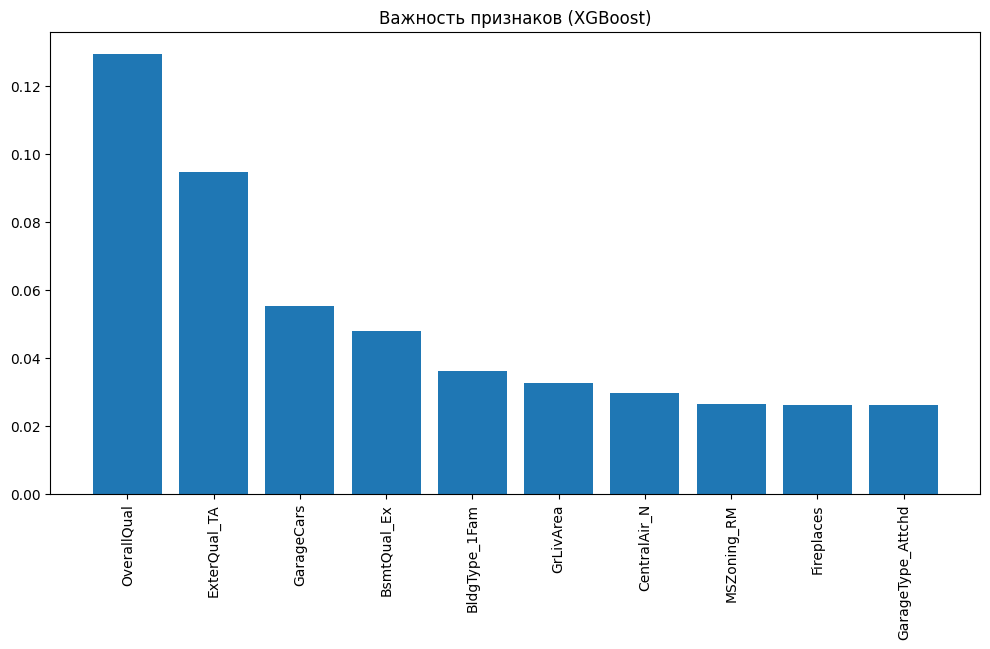

In [14]:
feature_names = X_train.columns

importances = random_xgb.best_estimator_.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Важность признаков (XGBoost)")
plt.bar(range(10), importances[indices][:10], align="center")
plt.xticks(range(10), feature_names[indices][:10], rotation=90)
plt.show()

In [28]:
X = data[:len(train)]
y = train['SalePrice'].map(np.log1p)

X_test = data[len(train):]

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [30]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(2, 6),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.4, 1.0),
    'colsample_bytree': uniform(0.4, 1.0),
    'min_child_weight': randint(1, 10),
}

model_xgb = XGBRegressor(random_state=42, n_jobs=-1)

random_xgb = RandomizedSearchCV(
    model_xgb,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=make_scorer(log_mae, greater_is_better=False), 
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_xgb.fit(X_train, y_train)

print("\nЛучшие параметры (RandomizedSearch):", random_xgb.best_params_)
print("Лучший MAE (RandomizedSearch):", -random_xgb.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Лучшие параметры (RandomizedSearch): {'colsample_bytree': 0.48085332633271527, 'learning_rate': 0.12089633681842132, 'max_depth': 2, 'min_child_weight': 6, 'n_estimators': 379, 'subsample': 0.8703006344460384}
Лучший MAE (RandomizedSearch): 15271.484341255022


In [31]:
param_dist_gb = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.2),  
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10)
}

gb = GradientBoostingRegressor(random_state=42)

random_gb = RandomizedSearchCV(
    gb,
    param_distributions=param_dist_gb,
    n_iter=50,
    cv=5,
    scoring=make_scorer(log_mae, greater_is_better=False),
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_gb.fit(X_train, y_train)

print("\nЛучшие параметры (RandomizedSearch):", random_gb.best_params_)
print("Лучший MAE (RandomizedSearch):", -random_gb.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Лучшие параметры (RandomizedSearch): {'learning_rate': 0.09989013482764068, 'max_depth': 3, 'min_samples_split': 9, 'n_estimators': 296}
Лучший MAE (RandomizedSearch): 15867.936786471051


In [32]:
param_dist_rf = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(randint(5, 30).rvs(10)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_rf = RandomizedSearchCV(
    rf, 
    param_distributions=param_dist_rf,
    n_iter=50,
    cv=5,
    scoring=make_scorer(log_mae, greater_is_better=False),
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_rf.fit(X_train, y_train)

print("\nЛучшие параметры (RandomizedSearch):", random_rf.best_params_)
print("Лучший MAE (RandomizedSearch):", -random_rf.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Лучшие параметры (RandomizedSearch): {'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 97}
Лучший MAE (RandomizedSearch): 17899.589105382365


In [33]:
models = {
    'xgb': XGBRegressor(**random_xgb.best_params_, random_state=42),
    'rf': RandomForestRegressor(**random_rf.best_params_, random_state=42),
    'gb': GradientBoostingRegressor(**random_gb.best_params_, random_state=42)
}

# Обучение и предсказание на валидации
val_preds = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    val_preds[name] = model.predict(X_val)
    print(f"{name} MAE: {log_mae(y_val, val_preds[name]):.4f}")

xgb MAE: 15687.2942
rf MAE: 17279.5628
gb MAE: 16187.2890


In [34]:
from scipy.optimize import minimize

# Матрица предсказаний (каждый столбец — предсказания одной модели)
pred_matrix = np.column_stack(list(val_preds.values()))

# Функция для оптимизации (минимизация MAE)
def blend_mae(weights):
    blended_pred = np.average(pred_matrix, axis=1, weights=weights)
    return log_mae(y_val, blended_pred)

# Ограничения: веса >= 0 и их сумма = 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = [(0, 1)] * len(models)  # Веса от 0 до 1

# Начальные веса (равномерное распределение)
initial_weights = np.ones(len(models)) / len(models)

# Оптимизация
result = minimize(
    blend_mae,
    initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

best_weights = result.x
print("Оптимальные веса:", dict(zip(models.keys(), best_weights)))

Оптимальные веса: {'xgb': 0.7198233730705815, 'rf': 0.20958660788703332, 'gb': 0.07059002380831626}
